# Vector data for exercises

In this course, we will use the vector dataset **Paavo**, which represents postal code area statistics collected by [Statistics Finland](https://www.stat.fi). Metadata description can be found on [Statistics Finland webpage](https://www.stat.fi/static/media/uploads/tup/paavo/paavo_kuvaus_en.pdf), see page 5 ff for field name descriptions.

The dataset includes variables about each postcode area, describing:

1. Population Structure (24 variables) HE
2. Educational Structure (7 variables) KO
3. Inhabitants' Disposable Monetary Income (7 variables) HR
4. Size and Stage in Life of Households (15 variables) TE
5. Households' Disposable Monetary Income (7 variables) TR
6. Buildings and Dwellings (8 variables) RA
7. Workplace Structure (26 variables) TP
8. Main Type of Activity (9 variables) PT

The overall goal of the exercises is to predict the median income based on other variables of the dataset. 

## Vector data preparations

In this notebook we will download all the necessary datasets, clean up some features, scale all numerical values, join auxiliary
data and encode text fields for machine learning purposes. We will save the result as geopackage.

The variable descriptions of this dataset can be found here in Finnish and English
* https://www.stat.fi/static/media/uploads/tup/paavo/paavo_lyhyt_kuvaus_2020_fi.pdf
* https://www.stat.fi/static/media/uploads/tup/paavo/paavo_lyhyt_kuvaus_2020_en.pdf

### Reference for later: Getting data used in the course from Paituli

In [ ]:
# Download Paavo dataset in ESRI shapefile format from Paituli


#check also use of request for same from python with wildcard

!wget -r -l inf -N -np -nH -x -c --cut-dirs=4 ftp://ftp.funet.fi/index/geodata/tilastokeskus/paavo/2022/pno_tilasto_2022* -P ./data/vector/

# creates dir any of dirs that does not exist and 2022 dir

#The region for each post code area is retrieved from a spatial join with a regions dataset (SuomenMaankuntajako_2020_10k.shp).

#TODO: check that this is the same as below!

# get administrative borders

#!wget -r -l inf -N -np -nH -x -c --cut-dirs=4 ftp://ftp.funet.fi/index/geodata/mml/hallintorajat_10k/2021-2022/ -P ./data/vector/
# did not work?
!wget -r -l inf -N -np -nH -x -c --cut-dirs=4 ftp://ftp.funet.fi/index/geodata/mml/hallintorajat_10k/2020/SuomenMaakuntajako_2020_10k* -P ./data/vector/




In [1]:
# Load all needed packages
import os
import zipfile
import time
# Data handling and plotting
import pandas as pd
import matplotlib.pyplot as plt
# Geospatial data handling 
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon, Polygon
# Machine learning data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Download data from URL
from urllib.request import urlretrieve
# for saving the scaler, uncomment following:
# from joblib import dump

### 1.1 Create directories if they do not already exist

In [2]:
directories = ['../data']

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

### 1.2 Download the Paavo data from Allas with urllib and unzip it to the data folder

In [3]:
urlretrieve('https://a3s.fi/gis-courses/gis_ml/paavo.zip', '../data/paavo.zip')

with zipfile.ZipFile('../data/paavo.zip', 'r') as zip_file:
    zip_file.extractall('../data')

### 1.3 Define file paths

In [4]:
zip_code_shapefile = '../data/paavo/pno_tilasto_2020.shp'
finnish_regions_shapefile = '../data/paavo/SuomenMaakuntajako_2020_10k.shp'
output_file_path = '../data/paavo/zip_code_data_after_preparation.gpkg'
scaler_path = '../data/paavo/zip_code_scaler.bin'

# 2. Reading and cleaning the data

Read the zip code dataset into a geopandas dataframe **original_gdf** and drop unnecessary rows and columns


In [6]:
### Read the data from a shapefile to a geopandas dataframe
original_gdf = gpd.read_file(zip_code_shapefile, encoding='utf-8')
print(f"Original dataframe size: {len(original_gdf.index)} zip codes with {len(original_gdf.columns)} columns")

### Drop all rows that have missing values or where average income is -1 (=not known) or 0
original_gdf = original_gdf.dropna()    
original_gdf = original_gdf[original_gdf["hr_mtu"]>0].reset_index(drop=True)

print(f"Dataframe size after dropping no data rows: {len(original_gdf.index)} zip codes with {len(original_gdf.columns)} columns")

### Remove some columns that are strings (namn, kunta = name of the municipality in Finnish and Swedish.)
### or which might make the modeling too easy ('hr_mtu','hr_tuy','hr_pi_tul','hr_ke_tul','hr_hy_tul','hr_ovy')
columns_to_be_removed_completely = ['namn','kunta','hr_ktu','hr_tuy','hr_pi_tul','hr_ke_tul','hr_hy_tul','hr_ovy']
original_gdf = original_gdf.drop(columns_to_be_removed_completely,axis=1)

print(f"Dataframe size after dropping columns with string values and columns that make modeling too easy : {len(original_gdf.index)} zip codes with {len(original_gdf.columns)} columns")


Original dataframe size: 3026 zip codes with 109 columns
Dataframe size after dropping no data rows: 2942 zip codes with 109 columns
Dataframe size after dropping columns with string values and columns that make modeling too easy : 2942 zip codes with 101 columns


In [6]:
original_gdf

,postinumer,nimi,euref_x,euref_y,pinta_ala,he_vakiy,he_naiset,he_miehet,he_kika,he_0_2,...,tp_u_kans,tp_x_tunt,pt_vakiy,pt_tyoll,pt_tyott,pt_0_14,pt_opisk,pt_elakel,pt_muut,geometry
0,00100,Helsinki Keskusta - Etu-Töölö,384979,6672361,2353278,18427.0,9754.0,8673.0,41.0,394.0,...,10.0,1.0,18284.0,10340.0,702.0,1863.0,1212.0,3350.0,817.0,"POLYGON ((385653.893 6671591.048, 385573.619 6..."
1,00120,Punavuori,385531,6671434,414010,7161.0,3793.0,3368.0,40.0,155.0,...,0.0,0.0,7108.0,3984.0,273.0,830.0,402.0,1230.0,389.0,"POLYGON ((385316.092 6671076.984, 385279.611 6..."
2,00130,Kaartinkaupunki,386244,6671474,428960,1523.0,788.0,735.0,41.0,41.0,...,13.0,0.0,1508.0,838.0,41.0,165.0,111.0,263.0,90.0,"POLYGON ((386212.111 6671061.262, 386176.826 6..."
3,00140,Kaivopuisto - Ullanlinna,386394,6670766,931841,7921.0,4335.0,3586.0,41.0,216.0,...,2.0,0.0,7865.0,4158.0,261.0,947.0,479.0,1560.0,460.0,"MULTIPOLYGON (((386577.050 6670280.544, 386552..."
4,00150,Eira - Hernesaari,385320,6670373,1367328,9385.0,5061.0,4324.0,40.0,238.0,...,8.0,0.0,9496.0,5514.0,438.0,972.0,535.0,1539.0,498.0,"MULTIPOLYGON (((384846.102 6669565.816, 384823..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,99910,Kaamanen-Partakko,501485,7678364,1787605274,167.0,69.0,98.0,54.0,1.0,...,0.0,0.0,168.0,57.0,13.0,9.0,11.0,73.0,5.0,"POLYGON ((525777.302 7700650.894, 525850.693 7..."
2938,99930,Sevettijärvi-Näätämö,544895,7710278,2660642404,227.0,93.0,134.0,51.0,1.0,...,-1.0,-1.0,233.0,100.0,25.0,19.0,5.0,79.0,5.0,"POLYGON ((574352.412 7709596.307, 573120.967 7..."
2939,99950,Karigasniemi,471619,7700224,1800546787,302.0,128.0,174.0,45.0,10.0,...,0.0,0.0,303.0,129.0,9.0,57.0,14.0,85.0,9.0,"POLYGON ((450197.347 7670193.165, 450054.015 7..."
2940,99980,Utsjoki Keskus,497850,7729733,2858974855,686.0,321.0,365.0,50.0,11.0,...,0.0,0.0,689.0,249.0,24.0,87.0,36.0,268.0,25.0,"POLYGON ((519583.786 7768425.325, 519615.030 7..."


### 2.1 Exploratory data analysis


#### 2.1.1 Visualization

If plotting maps with matplotlib is not familiar. Here are some things you can play with
* **figsize** - different height, width
* **column** - try other zip code values
* **cmap** - this is the color map, here are the possibile options https://matplotlib.org/3.3.1/tutorials/colors/colormaps.html

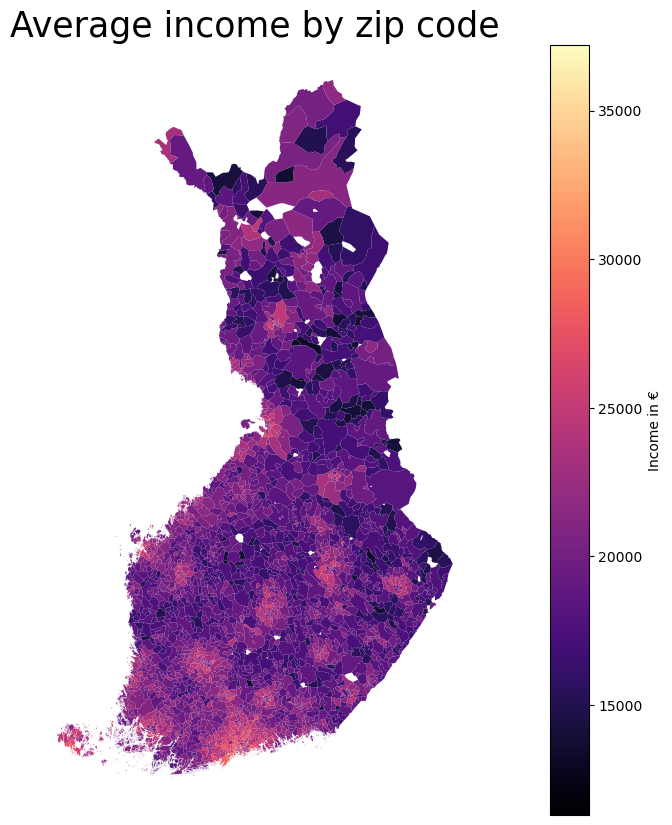

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
# set title for the full plot
ax.set_title("Average income by zip code", fontsize=25)
# turn off all axes
ax.set_axis_off()
# plot the average income
plot = original_gdf.plot(column='hr_mtu', ax=ax, legend=True, cmap="magma")
# set colorbar label
cax = fig.get_axes()[1]
cax.set_ylabel('Income in €');


#### 2.1.2 XXX

# 3. Feature Scaling

Feature Scaling is one of the most important data preparation steps. This is to avoid biasing algorithms that compute distances between features (e.g. like KNN, SVM and other non-treebased) towards numerically larger values. Feature scaling also helps the algorithm to train and converge faster.
The most popoular scaling techniques are normalization and standardization.

## 3.1 Normalization or min-max scaling 

* X_new = (X - X_min)/(X_max - X_min)
* Used when features are of different scales, eg average size of household (te_takk) and number of inhabitants of a certain age class (he_x_y) 
* Scales the values into range [0,1] or [-1,1]
* Data should not have any large outliers (data exploration!), as the rest of the data will be squashed into narrow range. -> Standardization is better option
* Scikit-learn: [MinMaxScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

## 3.2 Standardization or Z-score normalization

* X_new = (X - mean)/std
* Used when "zero mean and unit standard deviation" needs to be ensured, we are standardizing to achieve equal variance of features
* Not bound to specific range
* less affected by outliers, as range is not set outliers will not have influence on the range of other values
* "1 implies that the value for that case is one standard deviation above the mean"
* Scikit-learn: [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)


In [1]:
### Get list of all column headings
all_columns = list(original_gdf.columns)

### List the column names that we don't want to be scaled, like zip-code and nimi (both regarded as string, cannot be scaled), median income (label) and geometry (cannot be scaled as is)
col_names_no_scaling = ['postinumer','nimi','hr_mtu','geometry']

### List of column names we want to scale. (all columns minus those we don't want)
col_names_to_scale = [column for column in all_columns if column not in col_names_no_scaling]

### Subset the data for only those to-be scaled
gdf = original_gdf[col_names_to_scale]

### Apply a Scikit StandardScaler() or MinMaxScaler() for all the columns left in dataframe
### You can also test both, store in different variables then
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaled_values_array = scaler.fit_transform(gdf)

### You can save the scaler for later use. If there suddenly would be more zip codes in Finland, we should use the same scaler.
# dump(scaler, scaler_path, compress=True)

### Result is a numpy ndarray, which we pack back into geopandas dataframe
gdf = pd.DataFrame(scaled_values_array)
gdf.columns = col_names_to_scale

### Join the non-scaled columns back with the the scaled columns by index
scaled_gdf = original_gdf[col_names_no_scaling].join(gdf)
scaled_gdf.head()

NameError: name 'original_gdf' is not defined

# 4. Feature encoding

* Most Machine Learning algorithms cannot handle categorical features per se, they have to be converted to numerical values
* Categorical features can be binary (True/False, 1/0), ordinal (low,medium,high) or nominal (monkey, donkey, tiger, penguin)

This does not make any sense, but to practice, we can add region names to the post codes. One of the most-used encoding techniques is **one-hot encoding**. This means that instead of one column with different names, we create <number of unique values in column> new columns and fill then with 1/0. -> Same information content but numerical cells and no hierarchy (as we would get when simply assigning a numerical value to each string) -> also called "dummy variables"

We use the pandas **get_dummies()** function for one-hot encoding. Scikit would also have a **OneHotEncoder()** transformer for this

* More information on one-hot encoding https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding
* It might not always be the best option. See other options https://towardsdatascience.com/stop-one-hot-encoding-your-categorical-variables-bbb0fba89809

### 4.1 Spatially join the region information to the dataset 

In [9]:
### Read the regions shapefile and choose only the name of the region and its geometry
finnish_regions_gdf = gpd.read_file(finnish_regions_shapefile)
finnish_regions_gdf = finnish_regions_gdf[['NAMEFIN','geometry']]

### A function we use to return centroid point geometry from a zip code polygon
def returnPointGeometryFromXY(polygon_geometry):
    ## Calculate x and y of the centroid
    centroid_x,centroid_y = polygon_geometry.centroid.x,polygon_geometry.centroid.y
    ## Create a shapely Point geometry of the x and y coords
    point_geometry = Point(centroid_x,centroid_y)
    return point_geometry

### Stash the polygon geometry to another column as we are going to overwrite the 'geometry' with centroid geometry
scaled_gdf['polygon_geometry'] = scaled_gdf['geometry']

### We will be joining the region name to zip codes according to the zip code centroid. 
### This calls the function above and returns centroid to every row
scaled_gdf["geometry"] = scaled_gdf['geometry'].apply(returnPointGeometryFromXY)

### Spatially join the region name to the zip codes using the centroid of zip codes and region polygons
scaled_gdf = gpd.sjoin(scaled_gdf,finnish_regions_gdf,how='inner',op='intersects')
scaled_gdf.tail()

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3472: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,postinumer,nimi,hr_mtu,geometry,euref_x,euref_y,pinta_ala,he_vakiy,he_naiset,he_miehet,...,pt_vakiy,pt_tyoll,pt_tyott,pt_0_14,pt_opisk,pt_elakel,pt_muut,polygon_geometry,index_right,NAMEFIN
2937,99910,Kaamanen-Partakko,14958.0,POINT (503361.568 7678497.460),0.652824,0.934983,0.252585,0.005023,0.004094,0.006178,...,0.005127,0.003996,0.005880,0.002072,0.002740,0.010694,0.003094,"POLYGON ((525777.302 7700650.894, 525850.693 7...",7,Lappi
2938,99930,Sevettijärvi-Näätämö,16891.0,POINT (548890.739 7711836.158),0.721755,0.963719,0.375958,0.007240,0.005732,0.008857,...,0.007596,0.007239,0.011307,0.004375,0.001245,0.011637,0.003094,"POLYGON ((574352.412 7709596.307, 573120.967 7...",7,Lappi
2939,99950,Karigasniemi,20854.0,POINT (471402.146 7701544.993),0.605400,0.954666,0.254414,0.010010,0.008120,0.011835,...,0.010255,0.009425,0.004071,0.013125,0.003487,0.012581,0.005569,"POLYGON ((450197.347 7670193.165, 450054.015 7...",7,Lappi
2940,99980,Utsjoki Keskus,20153.0,POINT (502680.384 7734902.492),0.647052,0.981236,0.403985,0.024194,0.021290,0.026051,...,0.024915,0.018474,0.010855,0.020032,0.008966,0.041359,0.015470,"POLYGON ((519583.786 7768425.325, 519615.030 7...",7,Lappi
2941,99990,Nuorgam,21797.0,POINT (536019.915 7755327.036),0.712512,1.000000,0.109397,0.006760,0.006619,0.006922,...,0.007292,0.007088,0.004975,0.009440,0.002989,0.007548,0.006188,"POLYGON ((538700.093 7735625.716, 531298.591 7...",7,Lappi


### 4.2 One-hot encode the region name

In [10]:
### Switch the polygon geometry back to the 'geometry' field and drop uselesss columns
scaled_gdf['geometry'] = scaled_gdf['polygon_geometry']
scaled_gdf.drop(['index_right','polygon_geometry'],axis=1, inplace=True)

### Encode the region name with the One-hot encoding (= in pandas, dummy encoding)
encoded_gdf = pd.get_dummies(scaled_gdf['NAMEFIN'])

### Join scaled gdf and encoded gdf together
scaled_and_encoded_gdf = scaled_gdf.join(encoded_gdf).drop('NAMEFIN',axis=1)

### The resulting dataframe has Polygon and Multipolygon geometries. 
### This upcasts the polygons to multipolygon format so all of them have the same format
scaled_and_encoded_gdf["geometry"] = [MultiPolygon([feature]) if type(feature) == Polygon else feature for feature in scaled_and_encoded_gdf["geometry"]]
print("Dataframe size after adding region name: " + str(len(scaled_and_encoded_gdf.index))+ " zip codes with " + str(len(scaled_and_encoded_gdf.columns)) + " columns")

### Print the tail of the dataframe
scaled_and_encoded_gdf.tail()

Dataframe size after adding region name: 2942 zip codes with 120 columns


,postinumer,nimi,hr_mtu,geometry,euref_x,euref_y,pinta_ala,he_vakiy,he_naiset,he_miehet,...,Lappi,Pirkanmaa,Pohjanmaa,Pohjois-Karjala,Pohjois-Pohjanmaa,Pohjois-Savo,Päijät-Häme,Satakunta,Uusimaa,Varsinais-Suomi
2937,99910,Kaamanen-Partakko,14958.0,"MULTIPOLYGON (((525777.302 7700650.894, 525850...",0.652824,0.934983,0.252585,0.005023,0.004094,0.006178,...,1,0,0,0,0,0,0,0,0,0
2938,99930,Sevettijärvi-Näätämö,16891.0,"MULTIPOLYGON (((574352.412 7709596.307, 573120...",0.721755,0.963719,0.375958,0.007240,0.005732,0.008857,...,1,0,0,0,0,0,0,0,0,0
2939,99950,Karigasniemi,20854.0,"MULTIPOLYGON (((450197.347 7670193.165, 450054...",0.605400,0.954666,0.254414,0.010010,0.008120,0.011835,...,1,0,0,0,0,0,0,0,0,0
2940,99980,Utsjoki Keskus,20153.0,"MULTIPOLYGON (((519583.786 7768425.325, 519615...",0.647052,0.981236,0.403985,0.024194,0.021290,0.026051,...,1,0,0,0,0,0,0,0,0,0
2941,99990,Nuorgam,21797.0,"MULTIPOLYGON (((538700.093 7735625.716, 531298...",0.712512,1.000000,0.109397,0.006760,0.006619,0.006922,...,1,0,0,0,0,0,0,0,0,0


# 5. Write the pre-processed zip code data to file as a Geopackage

In [11]:
### Write the prepared zipcode dataset to a geopackage
scaled_and_encoded_gdf.to_file(output_file_path, driver="GPKG")

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
